# Electron Spin Resonance
Now using similar functions to the updated pauli notebook.

In [1]:
%matplotlib inline
import local_broom

Added 'quench/' and 'quench/libraries' for easy importing.


In [2]:
# Automagically reload modules when they are edited
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from qcodes import Instrument, Station
from monty import Monty
import MDAC
from may.dots import getvoltages
from may.custom_devices import connect_to_gb, newSiDot
from liveplot import LivePlot
from fridge import Fridge
import esr
from shfqc import SHFQC
from monty import Monty
import time
import logging

from qcodes.instrument_drivers.stanford_research.SR860 import SR860
from qcodes.instrument_drivers.agilent.E8267C import E8267

In [4]:
# channels = ["MW_I", "P1", "P2", "J", "MW_Q"]
# channel_addr = [0, 1, 2, 3, 5]

channels = ["P1", "P2", "J", "MW"]
channel_addr = [1, 2, 3, 5]


# channels = ["MW"]
# channel_addr = [5]

shfqc = SHFQC(channels, channel_addr, "measure")
shfqc.connect()

Connecting to device DEV12158
Creating new command tables


In [6]:
try:
    mdac = Instrument.find_instrument("mdac")
    mdac.close()
except KeyError:
    print('Attempting to remove instrument with name mdac. Does not exist')

mdac = MDAC.MDAC('mdac', 'ASRL11::INSTR')

try:
    lockin = Instrument.find_instrument("lockin")
    lockin.close()
except KeyError:
    print("Cannot remove instrument with name lockin. Does not exist")

scfg = Station(config_file='/Users/LD2007/Documents/Si_CMOS_james/measurements/system.yaml')

#lockin = scfg.load_instrument('sr860_top')
#psg = scfg.load_instrument('PSG')

lockin = SR860('lockin', 'TCPIP::192.168.0.108::inst0::INSTR')
psg = E8267('psg', 'TCPIP0::192.168.0.109::inst0::INSTR')


gb_control_si = connect_to_gb(mdac)  # Create our custom MDAC mappings
si = newSiDot(mdac)
fridge = Fridge("BlueFors_LD")

Attempting to remove instrument with name mdac. Does not exist
Connected to: QNL Sydney MDAC (serial:0x32353532353551040030003E, firmware:1.8) in 4.27s
Cannot remove instrument with name lockin. Does not exist
Connected to: Stanford_Research_Systems SR860 (serial:004279, firmware:V1.51) in 0.12s
Connected to: Agilent Technologies E8267D (serial:US50420058, firmware:C.06.25) in 0.10s
Loading GB driver and connecting
Manually Open Breakout_box_top_ch15_LCB
Manually Open Breakout_box_bot_ch09_RCB
Manually Open Breakout_box_bot_ch17_RG
Manually Open Breakout_box_top_ch17_ResB
Manually Open Breakout_box_top_ch19_P3
Manually Open Breakout_box_top_ch13_P2
Manually Open Breakout_box_top_ch04_P1
Manually Open Breakout_box_top_ch02_SETB
Manually Open Breakout_box_bot_ch04_SRB
Manually Open Breakout_box_bot_ch06_SLB
Manually Open Breakout_box_top_ch10_ST
Manually Open Breakout_box_top_ch25_bias
Using base URL https://qphys1114.research.ext.sydney.edu.au/therm_flask/BlueFors_LD


In [7]:
# Disconnect from all devices
disconnect = False
if disconnect:
    shfqc.disconnect()
    try:
        mdac = Instrument.find_instrument("mdac")
        mdac.close()
    except KeyError:
        print('Attempting to remove instrument with name mdac. Does not exist')
    try:
        lockin = Instrument.find_instrument("lockin")
        lockin.close()
    except KeyError:
        print("Cannot remove instrument with name sr860_top. Does not exist")
    try:
        psg = Instrument.find_instrument("psg")
        psg.close()
    except KeyError:
        print('Attempting to remove instrument with name mdac. Does not exist')

In [8]:
# setup monty
experiment = {
    "desc": "Run ESR frequency sweep to determine qubit frequencies"
}

monty = Monty("rf.esr", experiment)

Loading existing experiment (ignoring given experiment parameters)
Note that no experimental data has been loaded.
Next run will have id 363


In [33]:
shfqc.drive_channels

['MW']

In [19]:
params = {
    "amplitude_volts": {  # define the amplitudes that should be used. (maximum 340mV, give in Volts)
        "mixed_pulse": {  # voltage amplitude for mixed state preperation
            "P1": -0.2,  # make sure keys match drive lines above
            "P2": 0.2,
        },
        "readout_pulse": {
            "P1": -0.0021,  #-0.0025,
            "P2": 0.0021,  #0.0025,
            "J": 0.0,
        },
        "ramp_rate": 13e-5,  # V/sample
    },
    "sweep_j": {
        "j_start": -0.15,
        "j_stop": -0.15,
    },
    "sweep_detuning": {
        "p1_start": -0.0015,
        "p1_stop": -0.0035,
        "p2_start": 0.0015,
        "p2_stop": 0.0035,
    },
    "readout": {
        "freq": 406.6e6,  # (Hz) try 406.2e6
        "gain": 0.95,  # If we set this to 1, then output overloads
        "time": 100e-6,  # sec
    },
    "mw": {  # Microwave ESR settings
        "freqs": {  # (Hz)
            "center": 1.0e9,  # 1.5e9,
            "start": 0, #  -400e6,
            "stop": 0, #  400e6,
            # steps determined by averaging/num_freqs
        },
        "psgfreqstart": 6.75e9,  # using upper sideband
        "psgfreqstop": 7.25e9,  # using upper sideband
        "gain": 0.8,  # If we set this to 1, then output overloads
        "span": 1e6,  # frequency span for chirp signal, if enabled
        "sampling_divider": 3,
    },
    "timings_sec": {  # all in seconds
        "mixed_initilise": 600e-6,
        "read": 100e-6,
        "settle": 3e-3,
        "trigger": 8e-3,  # metronome of the internal trigger
        "buffer": 10e-6,
        "mw_pulse": 50e-6,
        "sampling_divider": 6,  # playback waveform resolution 2^X
    },
    "powers": {  # in dB presets from UI
        "acq_in": 10,
        "acq_out": -10,
        "drive": 0,  # only 0 is supported
        "mw_drive": 0,  # conncted to to PSG
        "psg_drive": 7,  # just a guess for now, output of psg
    },
    "averaging": {
        "seqc_averages": 200,  # max 2**19 points
        "num_freqs": 501,
        "num_j": 1,
        "num_detuning": 50,
    },
    "gates": getvoltages(mdac),
    "temp": f"Mixing chamber {fridge.temp()} K",
}


# Dynamic variables
# create arrays of our sweeping paramters
# freq_steps = np.linspace(params["mw"]["freqs"]["start"],
#                     params["mw"]["freqs"]["stop"],
#                     params["averaging"]["num_freqs"])

freq_steps = np.linspace(params["mw"]["psgfreqstart"],
                    params["mw"]["psgfreqstop"],
                    params["averaging"]["num_freqs"])
j_steps = np.linspace(params["sweep_j"]["j_start"],
                    params["sweep_j"]["j_stop"],
                    params["averaging"]["num_j"])
p1_steps = np.linspace(params["sweep_detuning"]["p1_start"],
                    params["sweep_detuning"]["p1_stop"],
                    params["averaging"]["num_detuning"])
p2_steps = np.linspace(params["sweep_detuning"]["p2_start"],
                    params["sweep_detuning"]["p2_stop"],
                    params["averaging"]["num_detuning"])

In [20]:
def sweep_esr_freq():
    """1D ESR frequency sweep"""
    monty.newrun("freq_sweep", params)

    # setup channels to match parameters
    esr.setupchannels(shfqc, params)
    esr.setupsequencers(shfqc, params, print_programs=False)
    esr.setup_command_tables(shfqc, params)
    time.sleep(1)  # wait to make sure everything processed in time

    # run the real experiment
    esr.synchchannels(shfqc, [shfqc.qa_channel_name] + shfqc.drive_channels)
    shfqc["measure"].spectroscopy.result.length(2)
    time.sleep(2)
    
    result = np.zeros((params["averaging"]["num_freqs"], 2), dtype=np.complex64)

    # upload command tables
    p1 = params["amplitude_volts"]["readout_pulse"]["P1"]
    p2 = params["amplitude_volts"]["readout_pulse"]["P2"]
    j_g = params["amplitude_volts"]["readout_pulse"]["J"]
    mw_gain = params["mw"]["gain"]
    esr.movemeasurement(shfqc, p1, p2, j_g, mw_gain, params)  # set amplitudes

    esr.change_mw_freq(shfqc, params)  # reupload sequence with new waveform
    esr.upload_command_tables(shfqc)

    # strange bug somewhere, quick fix
    synth = shfqc['MW'].synthesizer()
    shfqc.device.synthesizers[synth].centerfreq(params["mw"]["freqs"]["center"])
    psg.power(params["powers"]["psg_drive"])

    # set up phase
    # shfqc["MW_I"].oscs[0].phase(0)
    # shfqc["MW_Q"].oscs[0].phase(90)
    
    print("Doing ESR 1D sweep")
    with LivePlot(freq_steps, xlabel="Frequency (Hz)", ylabel="Amplitude (dB)") as lplot: 
        for i, mw in enumerate(tqdm(freq_steps, desc="Frequency")):
    
            #shfqc["MW"].oscs[0].freq(mw)
            psg.frequency(mw)
            
            result[i, :] = esr.run_esr_experiment(shfqc)
            lplot.update(esr.autodb(result[:, 1]))

    results = {"data": result}
    monty.save(results)
    return results

In [21]:
results = sweep_esr_freq()

Started new run freq_sweep.170
Doing ESR 1D sweep


Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Run finished and took 0:20:03.365473.
Saving to freq_sweep.170.xz
Saving to experiment.yaml


In [67]:
def sweep_esr_freq_against_detuning():
    """2D ESR frequency sweep over different detuning points in PSB"""
    monty.newrun("freq_v_detuning", params)

    # setup channels to match parameters
    esr.setupchannels(shfqc, params)
    esr.setupsequencers(shfqc, params, print_programs=False)
    esr.setup_command_tables(shfqc, params)
    time.sleep(1)  # wait to make sure everything processed in time

    # run the real experiment
    esr.synchchannels(shfqc, [shfqc.qa_channel_name] + shfqc.drive_channels)
    shfqc["measure"].spectroscopy.result.length(2)
    time.sleep(2)
    
    result = np.zeros((params["averaging"]["num_detuning"], params["averaging"]["num_freqs"], 2), dtype=np.complex64)

    # upload command tables
    j = params["amplitude_volts"]["readout_pulse"]["J"]
    mw_amp = params["mw"]["gain"]

    esr.change_mw_freq(shfqc, params)  # reupload sequence with new waveform

    for i, (p1, p2) in enumerate(zip(tqdm(p1_steps, desc="Detuning"), p2_steps)):

        esr.movemeasurement(shfqc, p1, p2, j, mw_amp, params)  # set amplitudes
        esr.upload_command_tables(shfqc)
        
        for k, mw in enumerate(tqdm(freq_steps, desc="Frequency", leave=False)):

            #shfqc["MW"].oscs[0].freq(mw)
            psg.frequency(mw)
            result[i, k, :] = esr.run_esr_experiment(shfqc)

        monty.snapshot({"data": result})
    
    results = {"data": result}
    monty.save(results)
    return results

In [ ]:
results = sweep_esr_freq_against_detuning()

Run finished and took 0:01:01.521177.
Started new run freq_v_detuning.3


Detuning:   0%|          | 0/50 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Frequency:   0%|          | 0/501 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
#psg.power(15)
psg.output_rf("OFF")

In [63]:
def sweep_esr_j_vs_freq():
    """2D ESR frequency vs. J sweep"""
    monty.newrun("freq_sweep_v_J", params)

    # setup channels to match parameters
    esr.setupchannels(shfqc, params)
    esr.setupsequencers(shfqc, params, print_programs=False)
    esr.setup_command_tables(shfqc, params)
    time.sleep(1)  # wait to make sure everything processed in time

    # run the real experiment
    esr.synchchannels(shfqc, [shfqc.qa_channel_name] + shfqc.drive_channels)
    shfqc["measure"].spectroscopy.result.length(2)
    time.sleep(2)
    
    result = np.zeros((params["averaging"]["num_j"], params["averaging"]["num_freqs"], 2), dtype=np.complex64)

    # upload command tables
    p1 = params["amplitude_volts"]["readout_pulse"]["P1"]
    p2 = params["amplitude_volts"]["readout_pulse"]["P2"]
    j = params["amplitude_volts"]["readout_pulse"]["J"]
    mw_amp = params["mw"]["gain"]

    for i, j in enumerate(tqdm(j_steps, desc="J")):

        esr.change_mw_freq(shfqc, params)  # reupload sequence with new waveform
        esr.movemeasurement(shfqc, p1, p2, j, mw_amp, params)  # set amplitudes
        esr.upload_command_tables(shfqc)
        
        for k, mw in enumerate(tqdm(freq_steps, desc="Frequency")):

            #shfqc["MW"].oscs[0].freq(mw)
            psg.frequency(mw)
            result[i, k] = esr.run_esr_experiment(shfqc)

        monty.snapshot({"data": result})
        
    results = {"data": result}
    monty.save(results)
    return results


In [64]:
sweep_esr_j_vs_freq()

Started new run freq_sweep_v_J.34


J:   0%|          | 0/1 [00:00<?, ?it/s]

Frequency:   0%|          | 0/201 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Run finished and took 0:07:54.892067.
Saving to freq_sweep_v_J.34.xz
Saving to experiment.yaml


{'data': array([[[0.00798215-0.01273559j, 0.0079063 -0.01270289j],
         [0.00798547-0.01273604j, 0.00790862-0.01270167j],
         [0.00798295-0.01273651j, 0.00790837-0.01270088j],
         [0.00798261-0.01273533j, 0.00791243-0.01270155j],
         [0.00797837-0.01273129j, 0.00790467-0.01269739j],
         [0.007982  -0.01273678j, 0.00791049-0.01269884j],
         [0.00798434-0.01273462j, 0.0079164 -0.0127055j ],
         [0.00798813-0.01274106j, 0.00791351-0.01269863j],
         [0.00799006-0.01273736j, 0.00791504-0.012704j  ],
         [0.00798581-0.01273608j, 0.00790908-0.01269349j],
         [0.0079895 -0.01274005j, 0.00791891-0.01269807j],
         [0.00798719-0.01273325j, 0.00791131-0.01270141j],
         [0.0079901 -0.01274034j, 0.00791685-0.01270327j],
         [0.00799007-0.01273608j, 0.00791582-0.01269925j],
         [0.0079908 -0.012738j  , 0.0079148 -0.01269578j],
         [0.00798196-0.01273632j, 0.00791585-0.0126984j ],
         [0.00798623-0.01273471j, 0.0079174 -0.0

In [ ]:
def sweep_esr_detuning_vs_freq():
    """2D ESR frequency vs. J sweep"""
    monty.newrun("freq_sweep_v_J", params)

    # setup channels to match parameters
    esr.setupchannels(shfqc, params)
    esr.setupsequencers(shfqc, params, print_programs=False)
    esr.setup_command_tables(shfqc, params)
    time.sleep(1)  # wait to make sure everything processed in time

    # run the real experiment
    esr.synchchannels(shfqc, [shfqc.qa_channel_name] + shfqc.drive_channels)
    shfqc["measure"].spectroscopy.result.length(2)
    time.sleep(2)
    
    result = np.zeros((params["averaging"]["num_j"], params["averaging"]["num_freqs"], 2), dtype=np.complex64)

    # upload command tables
    p1 = params["amplitude_volts"]["readout_pulse"]["P1"]
    p2 = params["amplitude_volts"]["readout_pulse"]["P2"]
    j = params["amplitude_volts"]["readout_pulse"]["J"]
    mw_amp = params["mw"]["gain"]

    for i, j in enumerate(tqdm(j_steps, desc="J")):

        esr.change_mw_freq(shfqc, params)  # reupload sequence with new waveform
        esr.movemeasurement(shfqc, p1, p2, j, mw_amp, params)  # set amplitudes
        esr.upload_command_tables(shfqc)
        
        for k, mw in enumerate(tqdm(freq_steps, desc="Frequency")):

            #shfqc["MW"].oscs[0].freq(mw)
            psg.frequency(mw)
            result[i, k] = esr.run_esr_experiment(shfqc)

        monty.snapshot({"data": result})
        
    results = {"data": result}
    monty.save(results)
    return results

In [50]:
def sweep_esr_testing_freq():
    """1D ESR frequency sweep"""
    monty.newrun("test_freq_sweep", params)

    # setup channels to match parameters
    esr.setupchannels(shfqc, params)
    esr.setup_dummy_sequencers(shfqc, params, print_programs=False)
    #esr.setup_command_tables(shfqc, params)  # this only targets P1 and P2, is it needed?
    time.sleep(2)  # wait to make sure everything processed in time

    #esr.synchchannels(shfqc, ["MW"])  ### DONT USE SEEMS BUGGY

    # shouldn't have to do this, there is a bug somewhere
    # synth = shfqc['MW_I'].synthesizer()
    # shfqc.device.synthesizers[synth].centerfreq(params["mw"]["freqs"]["center"])
    # synth = shfqc['MW_Q'].synthesizer()
    # shfqc.device.synthesizers[synth].centerfreq(params["mw"]["freqs"]["center"])

    # shfqc["MW_I"].sines[0].phaseshift(0)
    # shfqc["MW_Q"].sines[0].phaseshift(90)

    # shfqc["MW_I"].oscs[0].freq(0)
    # shfqc["MW_Q"].oscs[0].freq(0)
    
    # upload command tables
    mw = params["mw"]["gain"]
    esr.upload_dummy_sequence(shfqc, mw, params)  # set amplitudes
    esr.upload_command_tables(shfqc)
        
    esr.run_dummy_sequence(shfqc)


In [52]:
sweep_esr_testing_freq()

Run finished and took 0:01:30.905311.
Started new run test_freq_sweep.151


Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
shfqc.sg_channel_names

['P1', 'P2', 'J', 'MW']

In [43]:
for i in range(6):
    shfqc.device.sgchannels[i].synchronization.enable(0)
shfqc.device.system.internaltrigger.synchronization.enable(0)
shfqc.device.qachannels[0].synchronization.enable(0)

In [16]:
esr.synchchannels(shfqc, ["MW"])

In [18]:
params["mw"]["freqs"]["start"]

0

## Plot data

In [22]:
# 1D plots

def plot_amp_phase(X, amp, phase, name="amp_phase", xlabel="P1 voltage", save=False):
    """Plot both amplitude and phase of a result."""
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)

    ax0.plot(X, amp, ".-", color="steelblue")
    ax1.plot(X, phase, ".-", color="orange")
    
    ax0.set_ylabel("Amplitude")
    ax1.set_ylabel("Phase")
    ax0.set_title(monty.plot_title + "." + name)
    ax1.set_xlabel(xlabel)
    
    ax0.grid()
    ax1.grid()
    fig.align_ylabels([ax0, ax1])
    plt.tight_layout()

    if save:
        monty.savefig(plt, name)

In [23]:
result = monty.loadrun("freq_sweep.170")

params = monty.parameters["parameters"]

data = result["data"]

Loading 'C:\Users\LD2007\Documents\Si_CMOS_james\data\rf/esr\freq_sweep.170.xz'


In [ ]:
psg.

In [24]:
ref = data[:, ::2]
mes = data[:, 1::2]

ref_amp = esr.autodb(ref)
ref_phase = esr.autodeg(ref)
mes_amp = esr.autodb(mes)
mes_phase = esr.autodeg(mes)  # add axis for unwrap?

# X axis (p1_steps)
# freq_steps = np.linspace(params["mw"]["freqs"]["start"],
#                     params["mw"]["freqs"]["stop"],
#                     params["averaging"]["num_freqs"])
freq_steps = np.linspace(params["mw"]["psgfreqstart"],
                    params["mw"]["psgfreqstop"],
                    params["averaging"]["num_freqs"])
X = freq_steps

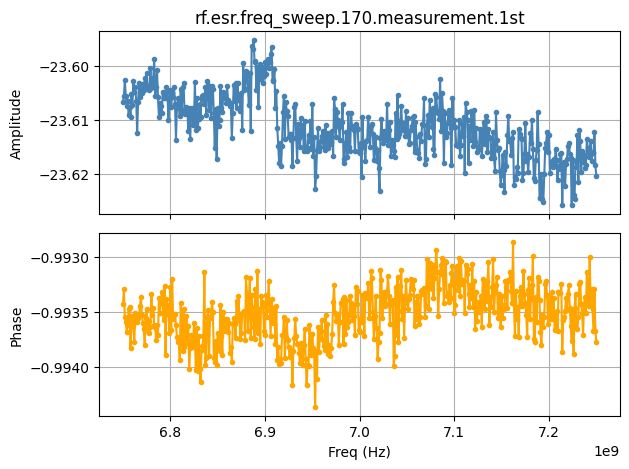

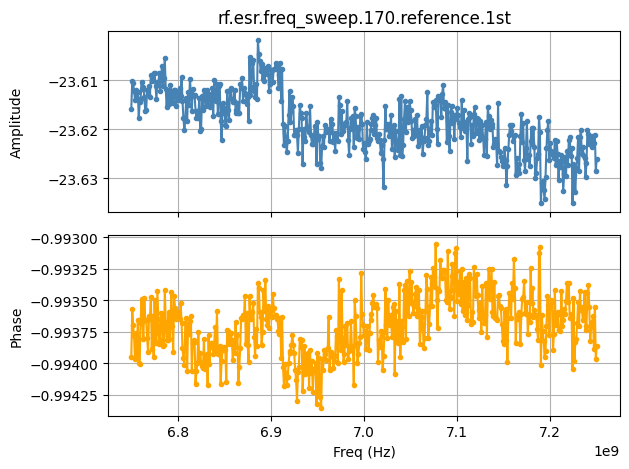

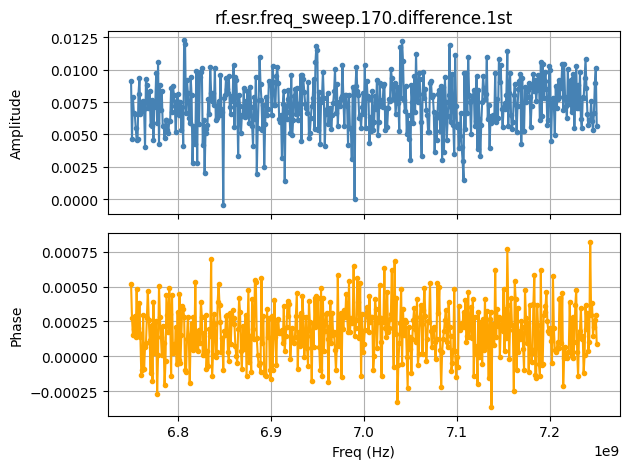

In [25]:
plot_amp_phase(X, mes_amp, mes_phase,
               name="measurement.1st",
               xlabel="Freq (Hz)",
               save=True)

plot_amp_phase(X, ref_amp, ref_phase,
               name="reference.1st",
               xlabel="Freq (Hz)",
               save=True)

plot_amp_phase(X, mes_amp-ref_amp, mes_phase-ref_phase,
               name="difference.1st",
               xlabel="Freq (Hz)",
               save=True)

In [192]:
result = monty.loadrun("freq_sweep_v_J.20")
#result = monty.loaddata("freq_sweep_v_J.7_SNAPSHOT.xz")

#params = monty.parameters["parameters"]

data = result["data"]

Loading 'C:\Users\LD2007\Documents\Si_CMOS_james\data\rf/esr\freq_sweep_v_J.20.xz'


In [193]:
ref = data[0, :, ::2]
mes = data[1, :, 1::2]

ref_amp = esr.autodb(ref)
ref_phase = esr.autodeg(ref)
mes_amp = esr.autodb(mes)
mes_phase = esr.autodeg(mes)  # add axis for unwrap?

# X axis (p1_steps)
# freq_steps = np.linspace(params["mw"]["freqs"]["start"],
#                     params["mw"]["freqs"]["stop"],
#                     params["averaging"]["num_freqs"])
freq_steps = np.linspace(params["mw"]["psgfreqstart"],
                    params["mw"]["psgfreqstop"],
                    params["averaging"]["num_freqs"])
X = freq_steps

ValueError: x and y must have same first dimension, but have shapes (100,) and (1000, 1)

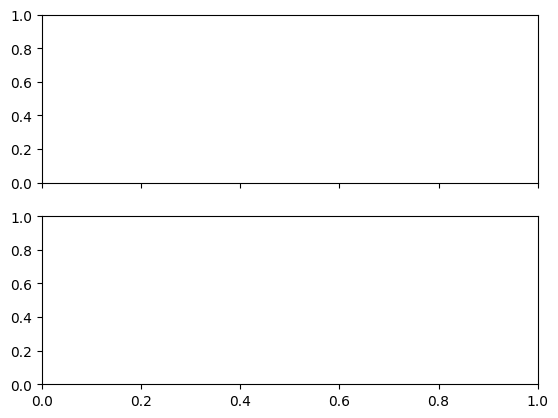

In [195]:
plot_amp_phase(X[1:], mes_amp[1:], mes_phase[1:],
               name="measurement.1st_J-0.15V",
               xlabel="Freq (Hz)",
               save=True)

plot_amp_phase(X[1:], ref_amp[1:], ref_phase[1:],
               name="reference.1st_J-0.15V",
               xlabel="Freq (Hz)",
               save=True)

plot_amp_phase(X[1:], mes_amp[1:]-ref_amp[1:], mes_phase[1:]-ref_phase[1:],
               name="difference.1st_J-0.15V",
               xlabel="Freq (Hz)",
               save=True)

Run finished and took 0:01:07.100250.
Started new run SET_ST_sweep.1
Sweeping Si28_quantum_dot_ST from 3.6V to 3.7V in 101 points.




  0%|                                                                                                                                                                                                               | 0/101 [00:00<?, ?it/s]

  1%|█▉                                                                                                                                                                                                     | 1/101 [00:00<00:52,  1.90it/s]

  2%|███▉                                                                                                                                                                                                   | 2/101 [00:00<00:45,  2.15it/s]

  3%|█████▉                                                                                                                                                                                                 | 3/101 [00:01<00:42,  2.28it/s]

  4%|███████▉                                 

Run finished and took 0:00:48.384204.
Saving to SET_ST_sweep.1.xz
Saving to experiment.yaml


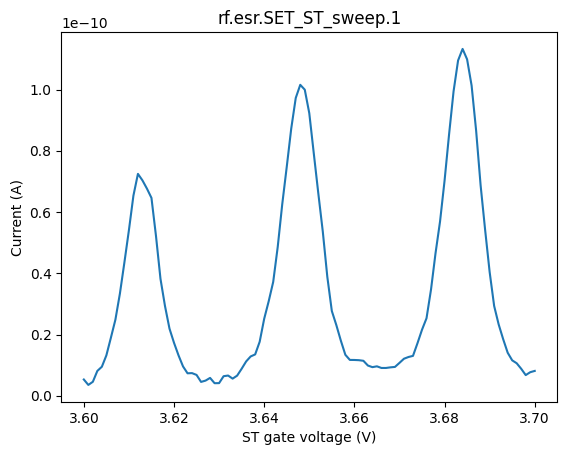

In [25]:
import swiper

low = 3.6
high = 3.7
pts = 101

parameters = {
    "desc": "Quick 1D scan of the SET over ST",
    "ST":   f"range from {low}v -> {high}v, over {pts} pts",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    }

monty.newrun("SET ST sweep", parameters)
result = swiper.sweep1d(lockin, si.ST, low, high, pts, delay_time=0.3, monty=monty)  # overlap points so we average

monty.save(result)

In [75]:
#si.ST(3.68)
target = 0.9e-10  # choose slightly on the right to match 
tol = 0.01e-10

def feedback(gate, lockin, target: float, stepsize=0.001, slope="up"):
    """
    Apply proportional feedback blindly
    """
    if slope == "up":
        sgn = 1
    elif slope == "down":
        sgn = -1
    else:
        raise (f"Unknown slope '{slope}'. Must be either 'up' or 'down'")

    r = lockin.R()
    error = (target - r) * sgn
    adjust = error / target * stepsize  # normalised error func
    g = gate() + adjust  # new gate voltage

    upperbound = 3.8
    lowerbound = 3.3

    if g > upperbound:  # upper bound
        print(f"Aborting feedback: correction voltage exceeds threshold, {g} > {upperbound}. No change to ST.")
    elif g < lowerbound:  # lower bound
        print(f"Aborting feedback: correction voltage fails to meet threshold, {g} < {lowerbound}. No change to ST.")
    #elif np.abs(r-target) > 0.03e-10:  # take a small step if good
    #    print(f"small step {np.abs(r-target)}")
    #    gate(gate() + adjust/4)
    #    time.sleep(0.5)
    else:
        gate(g)
        time.sleep(0.5)

def gettotarget():  # inherit global variables (bad!!!!)
    print(f"Target = {target:.4e}, tol = {tol}, initial ST = {si.ST()}")
    while np.abs(lockin.R()-target) > tol:
        feedback(si.ST, lockin, target, stepsize=0.001, slope="up")
        print(f"\rST = {si.ST():.4e}, lockin = {lockin.R():.4e}, delta = {np.abs(lockin.R()-target):.4e}", end="")
        time.sleep(0.1)
    print(f"\nFinal ST = {si.ST()}")

In [76]:
si.ST(3.68)
gettotarget()

Target = 9.0000e-11, tol = 1e-12, initial ST = 3.680002
ST = 3.6791e+00, lockin = 9.1023e-11, delta = 1.0185e-12
Final ST = 3.679138


In [87]:
from qcodes.instrument_drivers.oxford.MercuryiPS_VISA import MercuryiPS
magnet = MercuryiPS('magnet', 'TCPIP0::192.168.0.106::7020::SOCKET')

if False:
    magnet._set_target_and_ramp('z', 'simul', 0.4)
    time.sleep(100) #ramping at approx 1mT/s

Connected to: OXFORD INSTRUMENTS MERCURY IPS (serial:162550145, firmware:2.6.04.000) in 0.16s


In [27]:
result = monty.loadrun("freq_v_detuning.3")

params = monty.parameters["parameters"]

data = result["data"]

ref = data[:, :, 0]
mes = data[:, :, 1]

ref_amp = esr.autodb(ref)
ref_phase = esr.autodeg(ref)
mes_amp = esr.autodb(mes)
mes_phase = esr.autodeg(mes)  # add axis for unwrap?

# X axis (p1_steps)
freq_steps = np.linspace(params["mw"]["psgfreqstart"],
                    params["mw"]["psgfreqstop"],
                    params["averaging"]["num_freqs"])

p1_steps = np.linspace(params["sweep_detuning"]["p1_start"],
                    params["sweep_detuning"]["p1_stop"],
                    params["averaging"]["num_detuning"])
X = p1_steps


Loading 'C:\Users\LD2007\Documents\Si_CMOS_james\data\rf/esr\freq_v_detuning.3.xz'


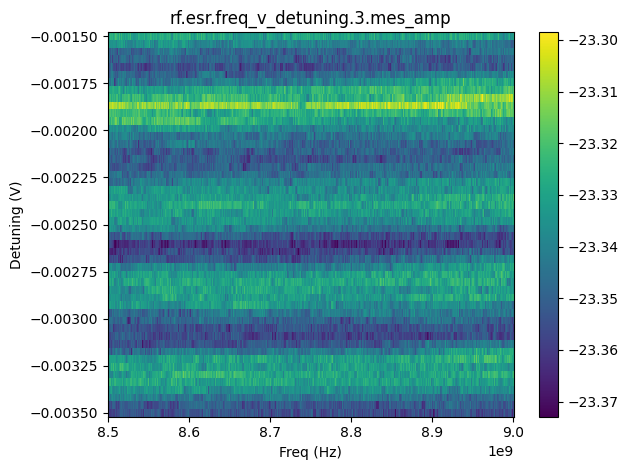

In [34]:
plt.figure()
plt.pcolormesh(freq_steps, p1_steps, mes_amp, shading="nearest")
plt.colorbar()
plt.ylabel("Detuning (V)")
plt.xlabel("Freq (Hz)")
plt.title(monty.plot_title + ".mes_amp")
plt.tight_layout()

monty.savefig(plt, "2d mes amp")

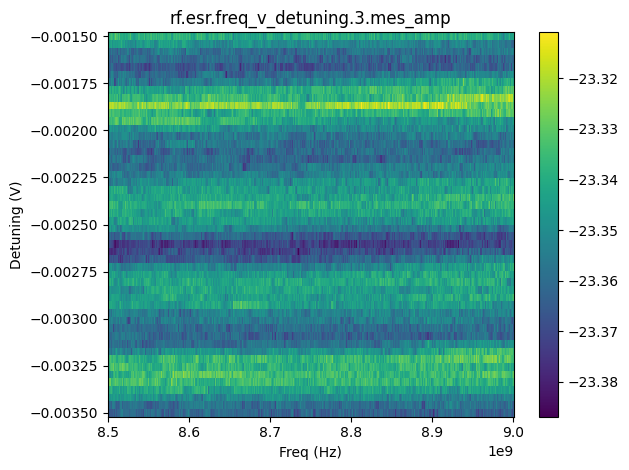

In [35]:
plt.figure()
plt.pcolormesh(freq_steps, p1_steps, ref_amp, shading="nearest")
plt.colorbar()
plt.ylabel("Detuning (V)")
plt.xlabel("Freq (Hz)")
plt.title(monty.plot_title + ".mes_amp")
plt.tight_layout()

monty.savefig(plt, "2d ref amp")

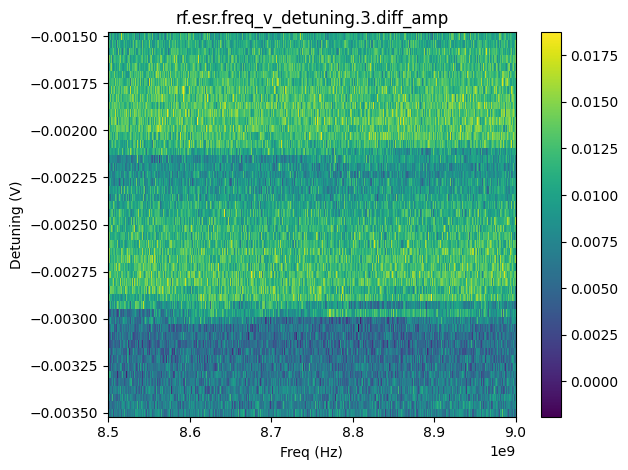

In [36]:
plt.figure()
plt.pcolormesh(freq_steps, p1_steps, mes_amp - ref_amp, shading="nearest")
plt.colorbar()
plt.ylabel("Detuning (V)")
plt.xlabel("Freq (Hz)")
plt.title(monty.plot_title + ".diff_amp")
plt.tight_layout()

monty.savefig(plt, "2d diff amp")